In [148]:
import os
import datetime
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

# 1. Przygotowanie danych z czujnika

In [149]:
recording_list_files = os.listdir('sensor')
print(recording_list_files)

['2022-12-03T184634_data.txt', '2022-12-03T184735_data.txt', '2022-12-03T184836_data.txt', '2022-12-03T184937_data.txt', '2022-12-03T185037_data.txt', '2022-12-03T185138_data.txt', '2022-12-03T185239_data.txt', '2022-12-03T185340_data.txt', '2022-12-03T185440_data.txt', '2022-12-03T185541_data.txt', '2022-12-03T185642_data.txt', '2022-12-03T185742_data.txt', '2022-12-03T185843_data.txt', '2022-12-03T185944_data.txt', '2022-12-03T190045_data.txt', '2022-12-03T190145_data.txt', '2022-12-03T190207_data.txt', '2022-12-03T190308_data.txt', '2022-12-03T190409_data.txt', '2022-12-03T190509_data.txt', '2022-12-03T190610_data.txt', '2022-12-03T190711_data.txt', '2022-12-03T190812_data.txt', '2022-12-03T190912_data.txt', '2022-12-03T191013_data.txt', '2022-12-03T191114_data.txt', '2022-12-03T191215_data.txt', '2022-12-03T191316_data.txt', '2022-12-03T191445_data.txt', '2022-12-03T191545_data.txt', '2022-12-03T191646_data.txt', '2022-12-03T191747_data.txt', '2022-12-03T191848_data.txt', '2022-12-

In [150]:
recordings = []
for filename in recording_list_files:
    file_dir = os.path.join('sensor', filename)
    file = open(file_dir, 'r').read()
    file_split = file.split('\n')[:-1]
    for x in file_split:
        e = x.split(';')
        e[0] = float(e[0])
        e[1] = int(e[1])
        e[2] = int(e[2])
        # e[0] = datetime.datetime.fromtimestamp(e[0])
        recordings.append(e)

print(recordings[0:20])

[[1670089595.191516, 3864, 1], [1670089595.215675, 3889, 1], [1670089595.24067, 3914, 1], [1670089595.26567, 3939, 2], [1670089595.290674, 3964, 2], [1670089595.315688, 3989, 2], [1670089595.340675, 4014, 2], [1670089595.365674, 4039, 1], [1670089595.390674, 4064, 1], [1670089595.415674, 4089, 1], [1670089595.440679, 4114, 1], [1670089595.465675, 4139, 1], [1670089595.490674, 4164, 1], [1670089595.515674, 4189, 1], [1670089595.540679, 4214, 1], [1670089595.565675, 4239, 1], [1670089595.590674, 4264, 1], [1670089595.615674, 4289, 1], [1670089595.640674, 4314, 1], [1670089595.665679, 4339, 1]]


## 1.2 Odstępy czasowe pomiędzy próbkami

Dzięki temu możliwe jest odzielenie ich do 3 poszczególnych nagrań video

Id of new recordings: 35924
Id of new recordings: 62235


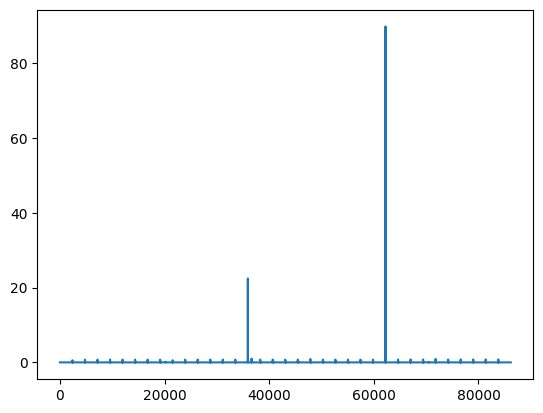

In [151]:
rs = []
recordings_new_id = []
for a in range(len(recordings) - 1):
    x = recordings[a]
    y = recordings[a + 1]
    r = y[0] - x[0]
    rs.append(r)

    if r > 10:
        print(f'Id of new recordings: {a}')
        recordings_new_id.append(a)

plt.plot(rs)
plt.show()

## 1.3 Odstępy pomiędzy podzielonymi próbkami
Podczas tworzenia nowego pliku można zauważyć duży odstęp

[35924, 62235]


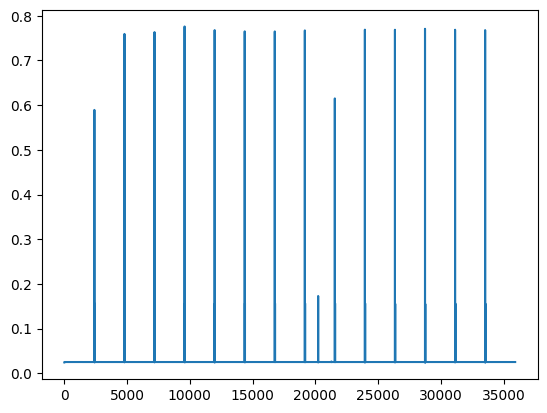

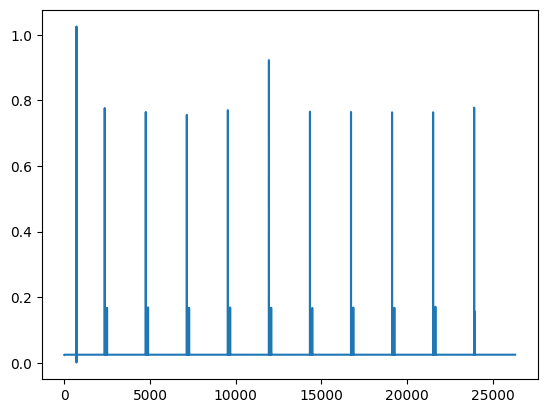

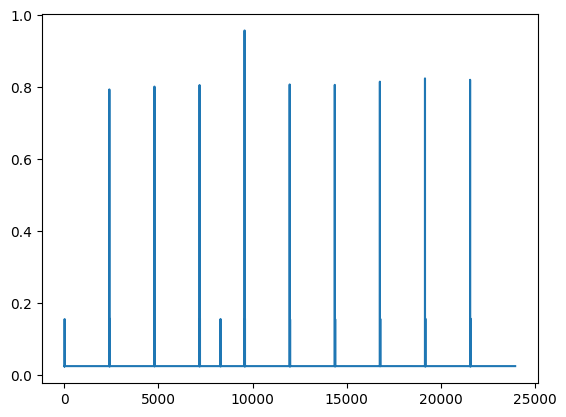

In [152]:
print(recordings_new_id)
recordings_divided = [
    recordings[:recordings_new_id[0]],
    recordings[recordings_new_id[0] + 1: recordings_new_id[1]],
    recordings[recordings_new_id[1] + 1:]
]

for recording_divided in recordings_divided:
    rs = []
    for a in range(len(recording_divided) - 1):
        x = recording_divided[a]
        y = recording_divided[a + 1]
        r = y[0] - x[0]
        rs.append(r)
    plt.plot(rs)
    plt.show()



## 1.4 Dodanie czasu względnego zamiast bezwzględnego

Dodatkowo zmiena jednostki do czasu fps w video

In [153]:
def round_to_multiple(number, multiple):
    return round(multiple * round(number / multiple), 2)


fps = 25
separation = 1 / 25

In [154]:
recordings_relative_divided = []
for recordings in recordings_divided:
    relative_times = set()  #Czasy nie powinny się powtarzać
    recordings_relative = []
    for i in range(len(recordings)):
        if i == 0:
            recordings_relative.append([0, recordings[i][1], recordings[i][2]])
            continue
        x = recordings[0]
        y = recordings[i]
        relative_time = y[0] - x[0]
        relative_time = round_to_multiple(relative_time, separation)
        # Jak czas się powtarza to jest pomijany
        if relative_time in relative_times:
            continue

        relative_times.add(relative_time)
        recordings_relative.append([relative_time, recordings[i][1], recordings[i][2]])
    recordings_relative_divided.append(recordings_relative)
print(recordings_relative_divided[0][:10])

[[0, 3864, 1], [0.04, 3889, 1], [0.08, 3939, 2], [0.12, 3989, 2], [0.16, 4014, 2], [0.2, 4064, 1], [0.24, 4089, 1], [0.28, 4139, 1], [0.32, 4189, 1], [0.36, 4214, 1]]


# 2. Nagrania video

In [155]:
video_list_files = os.listdir('videos')
print(video_list_files)

['GOPR1075.MP4', 'GOPR1076.MP4', 'GOPR1077.MP4']


## 2.1 Zbadanie średniej jasności pikseli

In [156]:
frames_light_times = []
for video_name in video_list_files:
    video_path = os.path.join('videos', video_name)
    cap = cv2.VideoCapture(video_path)
    frames_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_time = frames_count / fps
    frames_light_time = []

    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    pbar = tqdm(total=frames_count)
    succ = fail = 0
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            fail += 1
            continue
        else:
            succ += 1
        if succ == frames_count:
            break

        # cv2.imshow('Frame',frame)
        frame_light = np.average(frame)
        frame_time = round(succ / fps, 2)
        frames_light_time.append([frame_light, frame_time])

        pbar.update(1)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

    # print(succ, fail)
    cap.release()
    cv2.destroyAllWindows()
    frames_light_times.append(frames_light_time)


100%|█████████▉| 22243/22244.0 [07:20<00:00, 50.53it/s] 

  0%|          | 11/22244.0 [00:00<08:41, 42.67it/s]
  0%|          | 43/22244.0 [00:00<02:38, 140.30it/s]
  0%|          | 75/22244.0 [00:00<01:51, 199.27it/s]
  0%|          | 106/22244.0 [00:00<01:34, 234.70it/s]
  1%|          | 137/22244.0 [00:00<01:25, 257.44it/s]
  1%|          | 169/22244.0 [00:00<01:20, 274.26it/s]
  1%|          | 200/22244.0 [00:00<01:17, 285.07it/s]
  1%|          | 231/22244.0 [00:00<01:15, 290.96it/s]
  1%|          | 262/22244.0 [00:01<01:14, 293.31it/s]
  1%|▏         | 294/22244.0 [00:01<01:13, 299.41it/s]
  1%|▏         | 325/22244.0 [00:01<01:12, 301.95it/s]
  2%|▏         | 357/22244.0 [00:01<01:11, 304.97it/s]
  2%|▏         | 388/22244.0 [00:01<01:11, 304.45it/s]
  2%|▏         | 419/22244.0 [00:01<01:11, 304.69it/s]
  2%|▏         | 450/22244.0 [00:01<01:11, 305.06it/s]
  2%|▏         | 481/22244.0 [00:01<01:10, 306.52it/s]
  2%|▏         | 513/22244.0 [00:01<01:10, 308.69it/s]
  2%|▏    

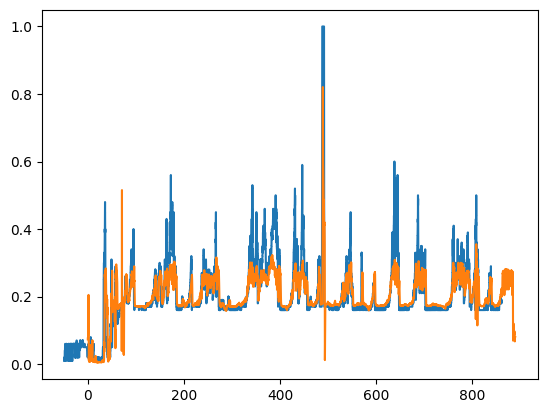

In [157]:
# print(frames_light_time[:10])
light_y = [x[0] / 256 for x in frames_light_times[0]]
light_x = [x[1] for x in frames_light_times[0]]


recordings_moved = [[x[0] - 49, x[1], x[2]] for x in recordings_relative_divided[0]]
# print(recordings_relative_divided[0][:10])
record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)

plt.show()